# Assignment 1

## Formalia:

Please read the [assignment overview page](https://github.com/suneman/socialdata2023/wiki/Assignments) carefully before proceeding. This page contains information about formatting (including formats etc.), group sizes, and many other aspects of handing in the assignment. 

_If you fail to follow these simple instructions, it will negatively impact your grade!_

**Due date and time**: The assignment is due on Monday February 27th, 2023 at 23:55. Hand in your files via [http://peergrade.io](http://peergrade.io/).

**Peergrading date and time**: _Remember that after handing in you have 1 week to evaluate a few assignments written by other members of the class_. 

## A1 Part 1: Visualizing patterns in the data

In this sub-assignment, we recreate some of the plots from Week 2. We look only at the focus-crimes.

In [10]:
import os
import calendar
import calplot

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
import missingno as msno
import numpy as np
from urllib.request import urlopen
import json
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#set notebook options
pd.options.mode.chained_assignment = None 
pd.set_option('display.max_columns', None)
plt.rcParams.update({'font.size': 10})
sns.set_style("white")
plt_color = 'cadetblue'


#### Crime data from San Fransisco Police Dept. 2003-2017

In [8]:
# Load SF crime data
filename = 'Police_Department_Incident_Reports__Historical_2003_to_May_2018.csv'
data = pd.read_csv(os.path.join('data',filename))
data = data[pd.to_datetime(data.Date).dt.year < 2018]

# Feature settings
data['DayOfWeek'] = pd.Categorical(data.DayOfWeek,
                                      categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday','Friday','Saturday','Sunday'],
                                      ordered=True)
data['Timestamp'] = pd.to_datetime(data["Date"] + data["Time"], format="%m/%d/%Y%H:%M")
data['year'] = data['Timestamp'].dt.year.astype(int)
data['Month'] = pd.Categorical(data['Timestamp'].dt.month_name(), categories=list(calendar.month_name), ordered=True)
data['Hour'] = data['Timestamp'].dt.hour.astype(int)
data['HoW'] = data['Timestamp'].dt.dayofweek * 24 + (data['Timestamp'].dt.hour + 1).astype(int)

data.shape

(2084466, 40)

First we check how many values are missing for each feature in the data set 

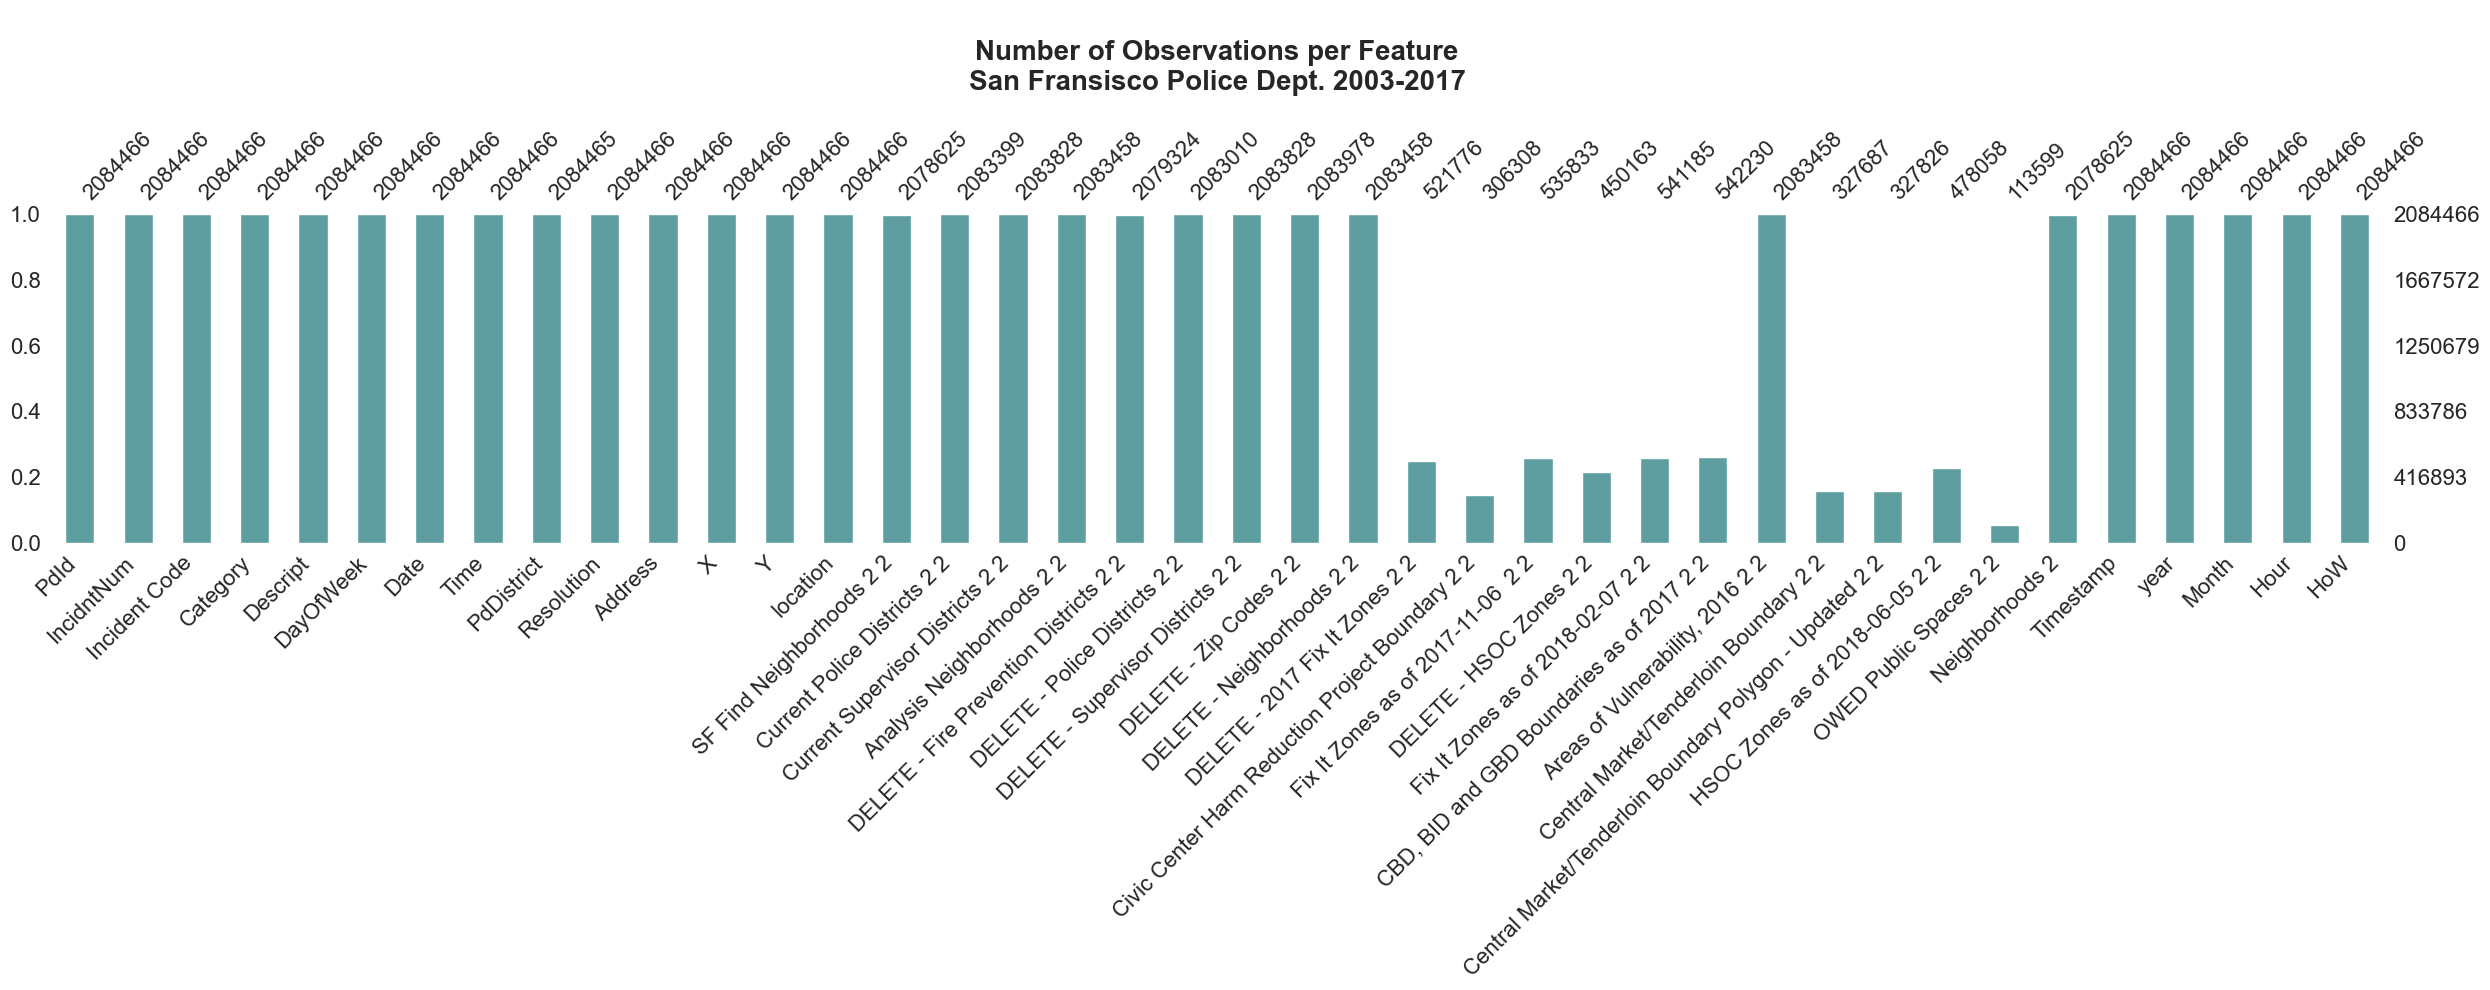

In [9]:
plt.figure(figsize=(20,10))
msno.bar(data, color=plt_color)
plt.title('\nNumber of Observations per Feature\nSan Fransisco Police Dept. 2003-2017\n', fontsize=20, weight='bold')
plt.tight_layout()
plt.show()

From the plot above, it seems like the most relevant features are not significantly impacted by missing values.

### Crime Frequencies by month, week day, hour & hour of week

For each set of plots below, describe the plots (as you would in the figure text in a report or paper), and pick a few aspects that stand out to you and comment on those (we provided a couple of ideas during class but it's OK to add more).

* First create the week-day plots, the months, the 24-hour cycle, and the 168 hours of the week as barcharts (Week 2, Part 2).


In [13]:
focuscrimes = set(['WEAPON LAWS', 'PROSTITUTION', 'DRIVING UNDER THE INFLUENCE', 'ROBBERY', 
                    'BURGLARY', 'ASSAULT', 'DRUNKENNESS', 'DRUG/NARCOTIC', 'TRESPASS', 'LARCENY/THEFT', 
                    'VANDALISM', 'VEHICLE THEFT', 'STOLEN PROPERTY', 'DISORDERLY CONDUCT'])

timeframe = ['Month','DayOfWeek','Hour','HoW']

# Get focus crimes-data
crime_df = data[data.Category.isin(focuscrimes)]
crime_df[['Category','Timestamp','year']+timeframe].head()

Category           Timestamp  year     Month DayOfWeek  Hour  HoW
0        ROBBERY 2004-11-22 17:50:00  2004  November    Monday    17   18
1  VEHICLE THEFT 2005-10-18 20:00:00  2005   October   Tuesday    20   45
2  VEHICLE THEFT 2004-02-15 02:00:00  2004  February    Sunday     2  147
4        ASSAULT 2010-11-21 17:00:00  2010  November    Sunday    17  162
5        ASSAULT 2013-04-02 15:50:00  2013     April   Tuesday    15   40

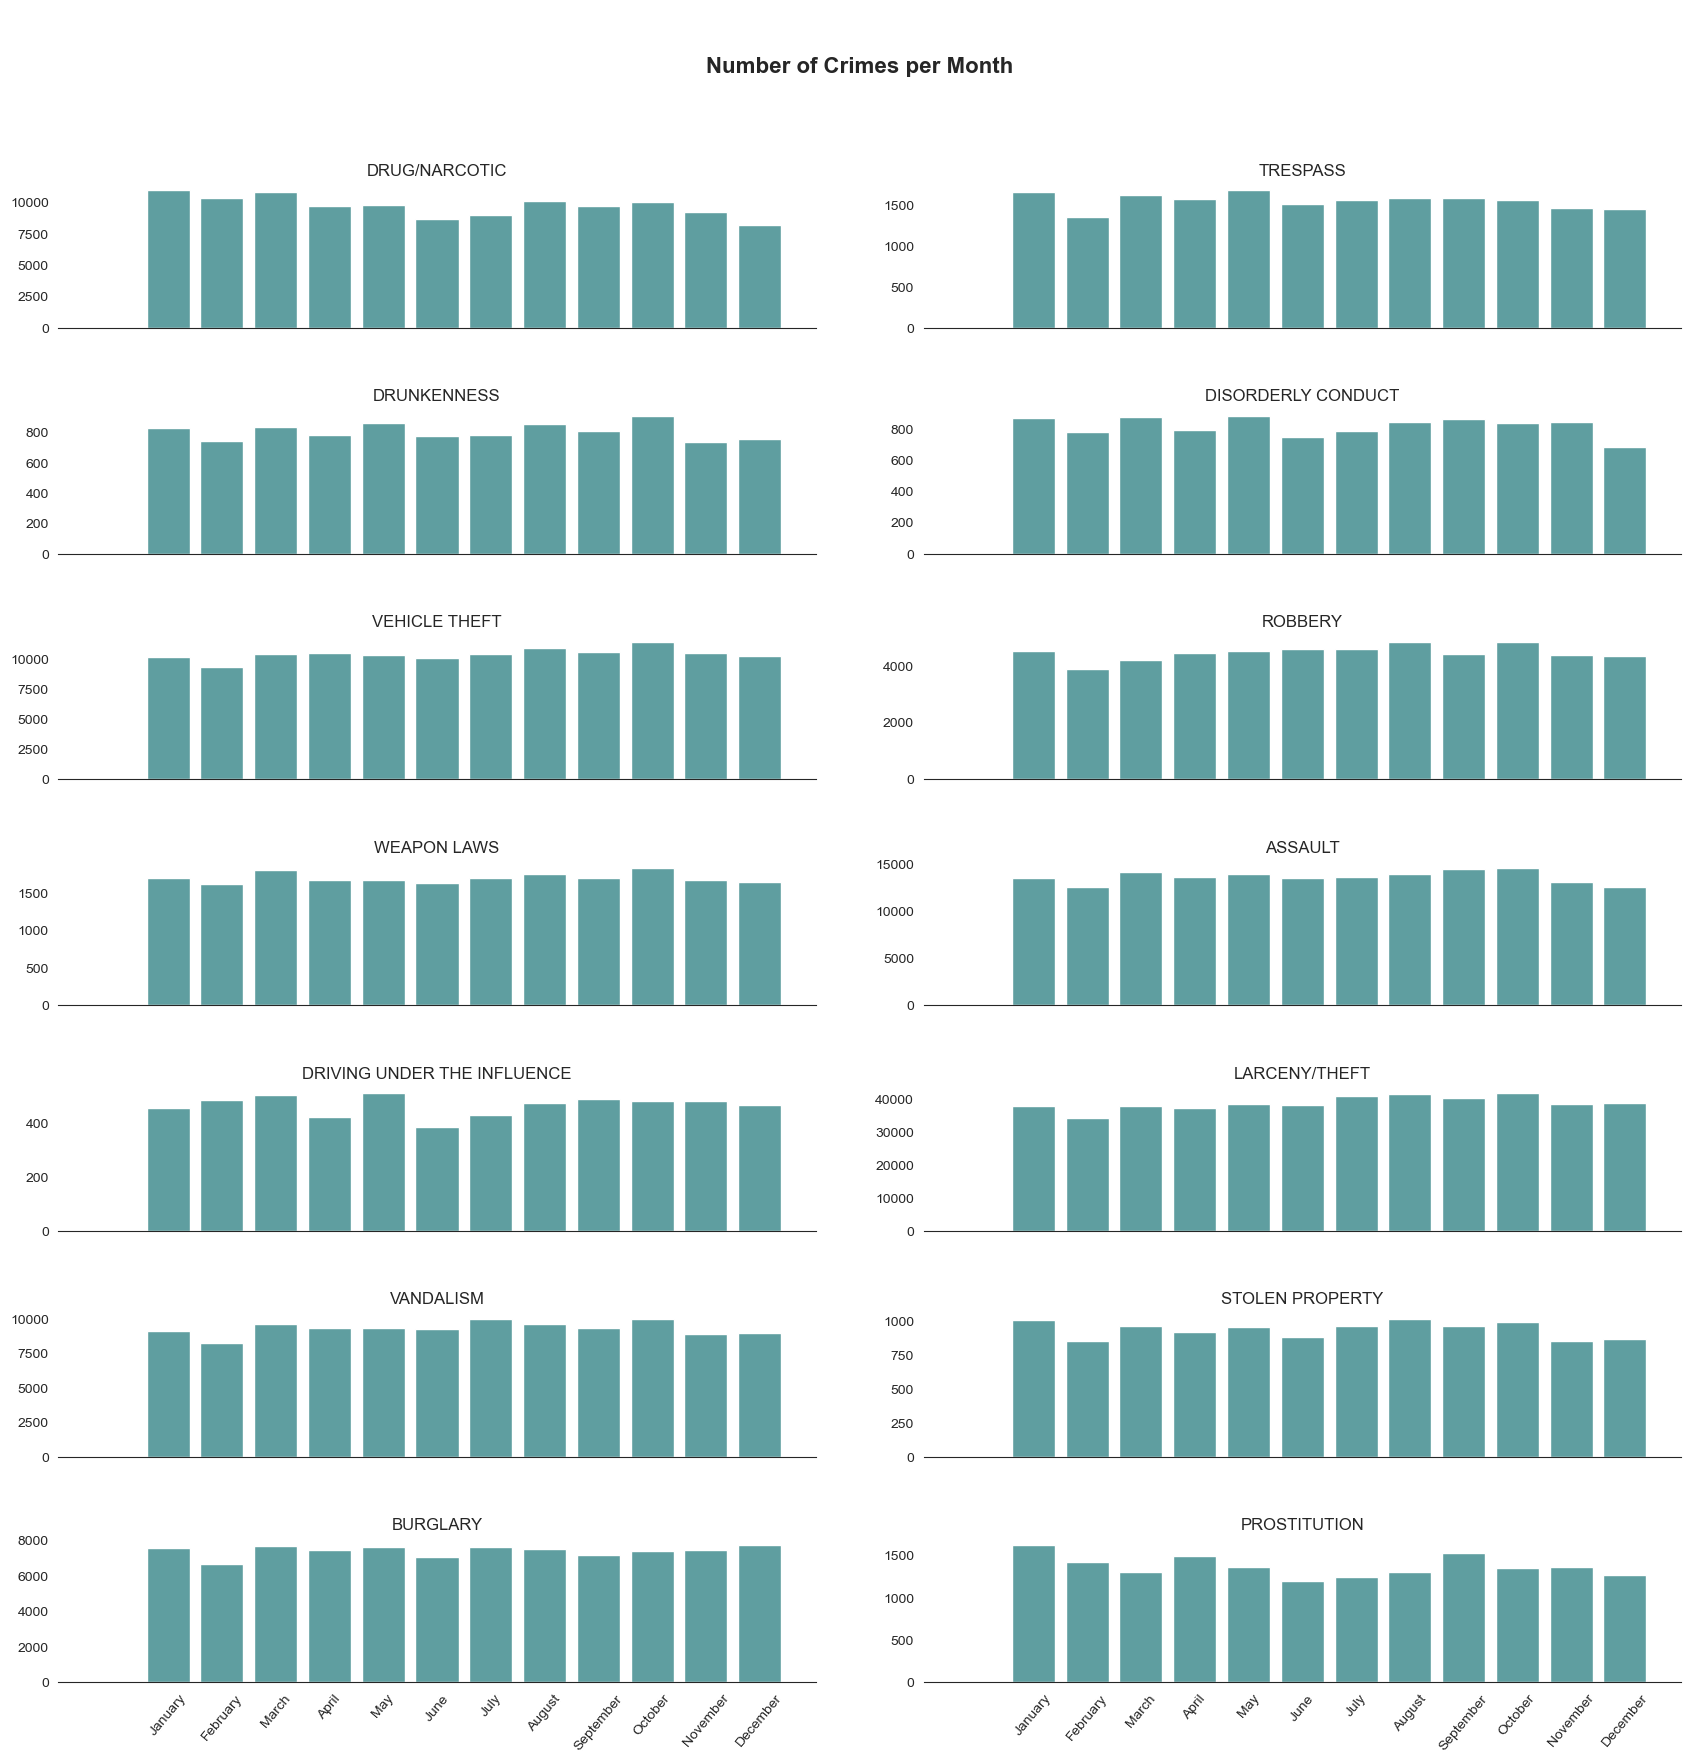

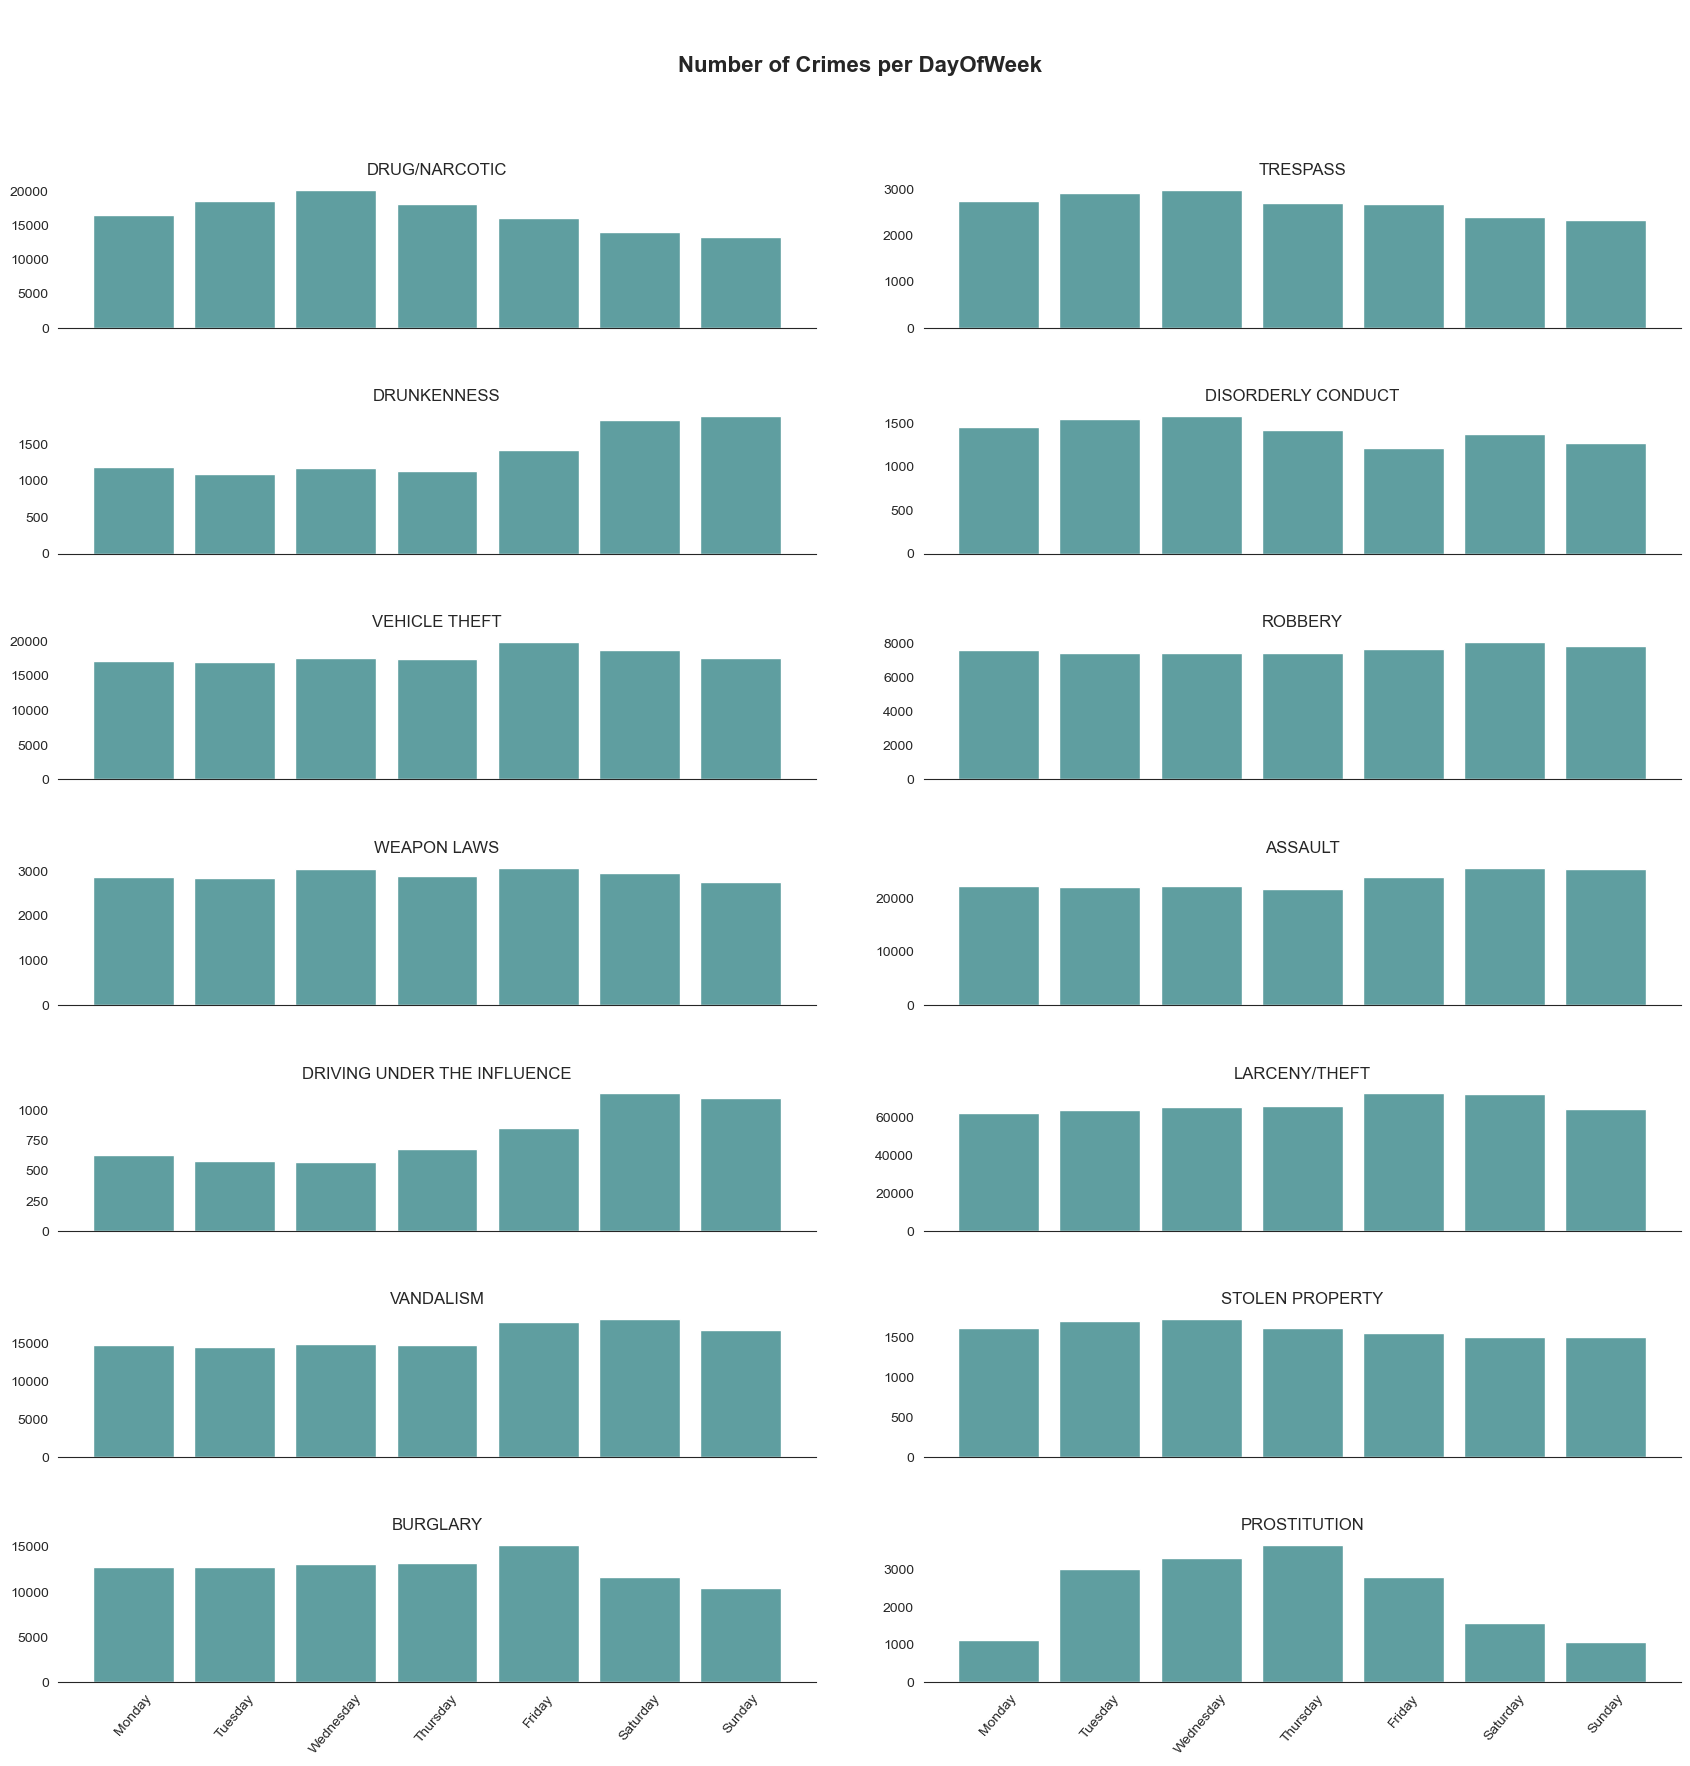

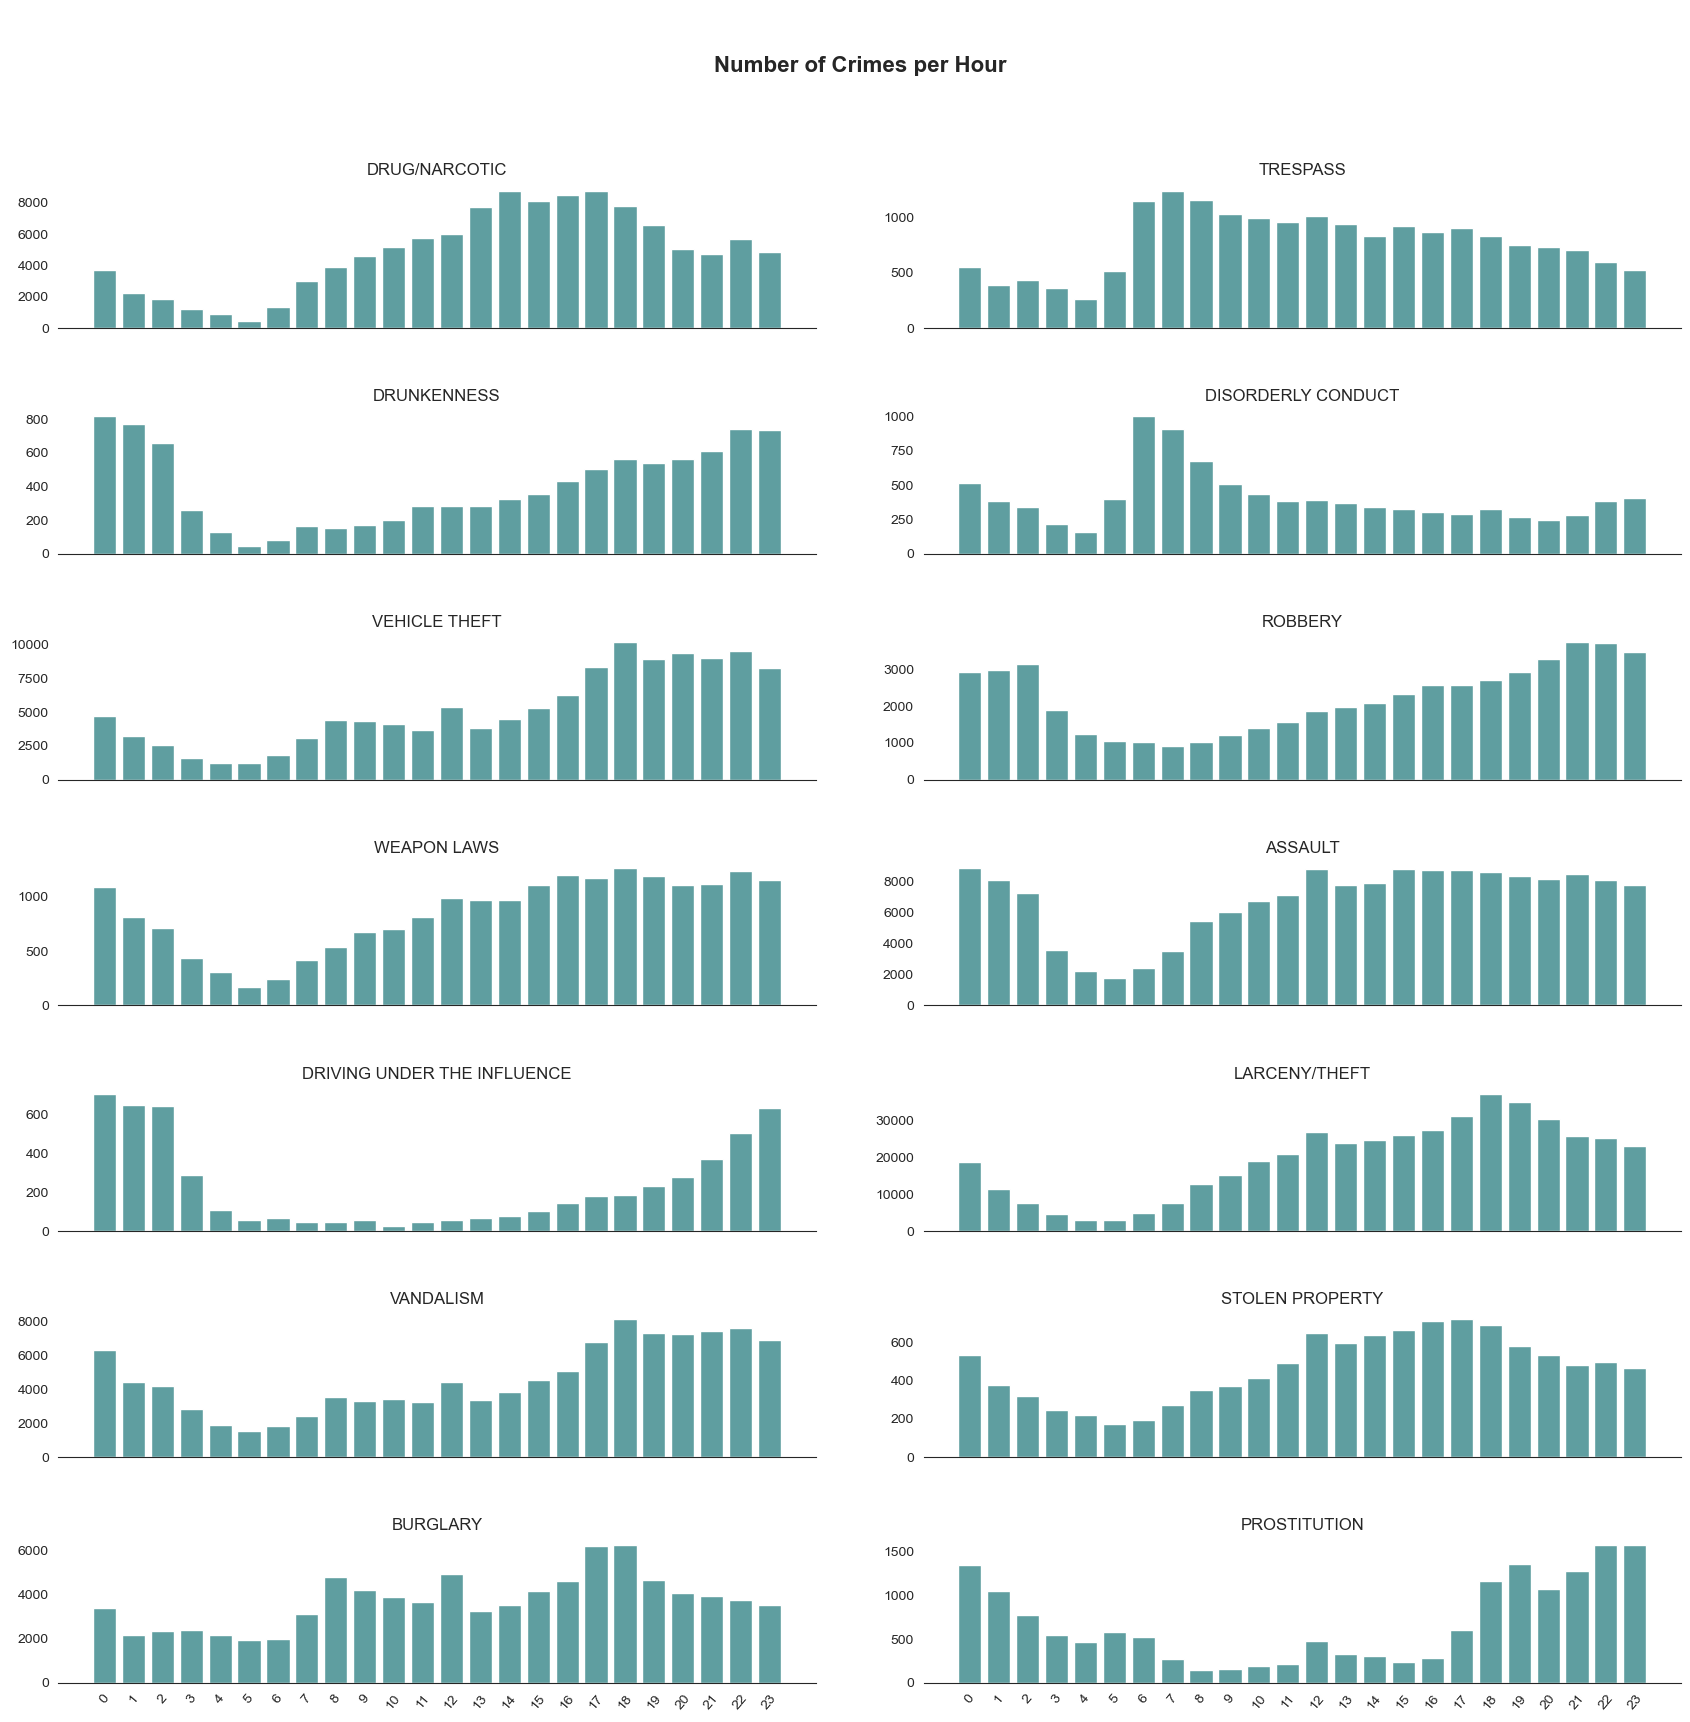

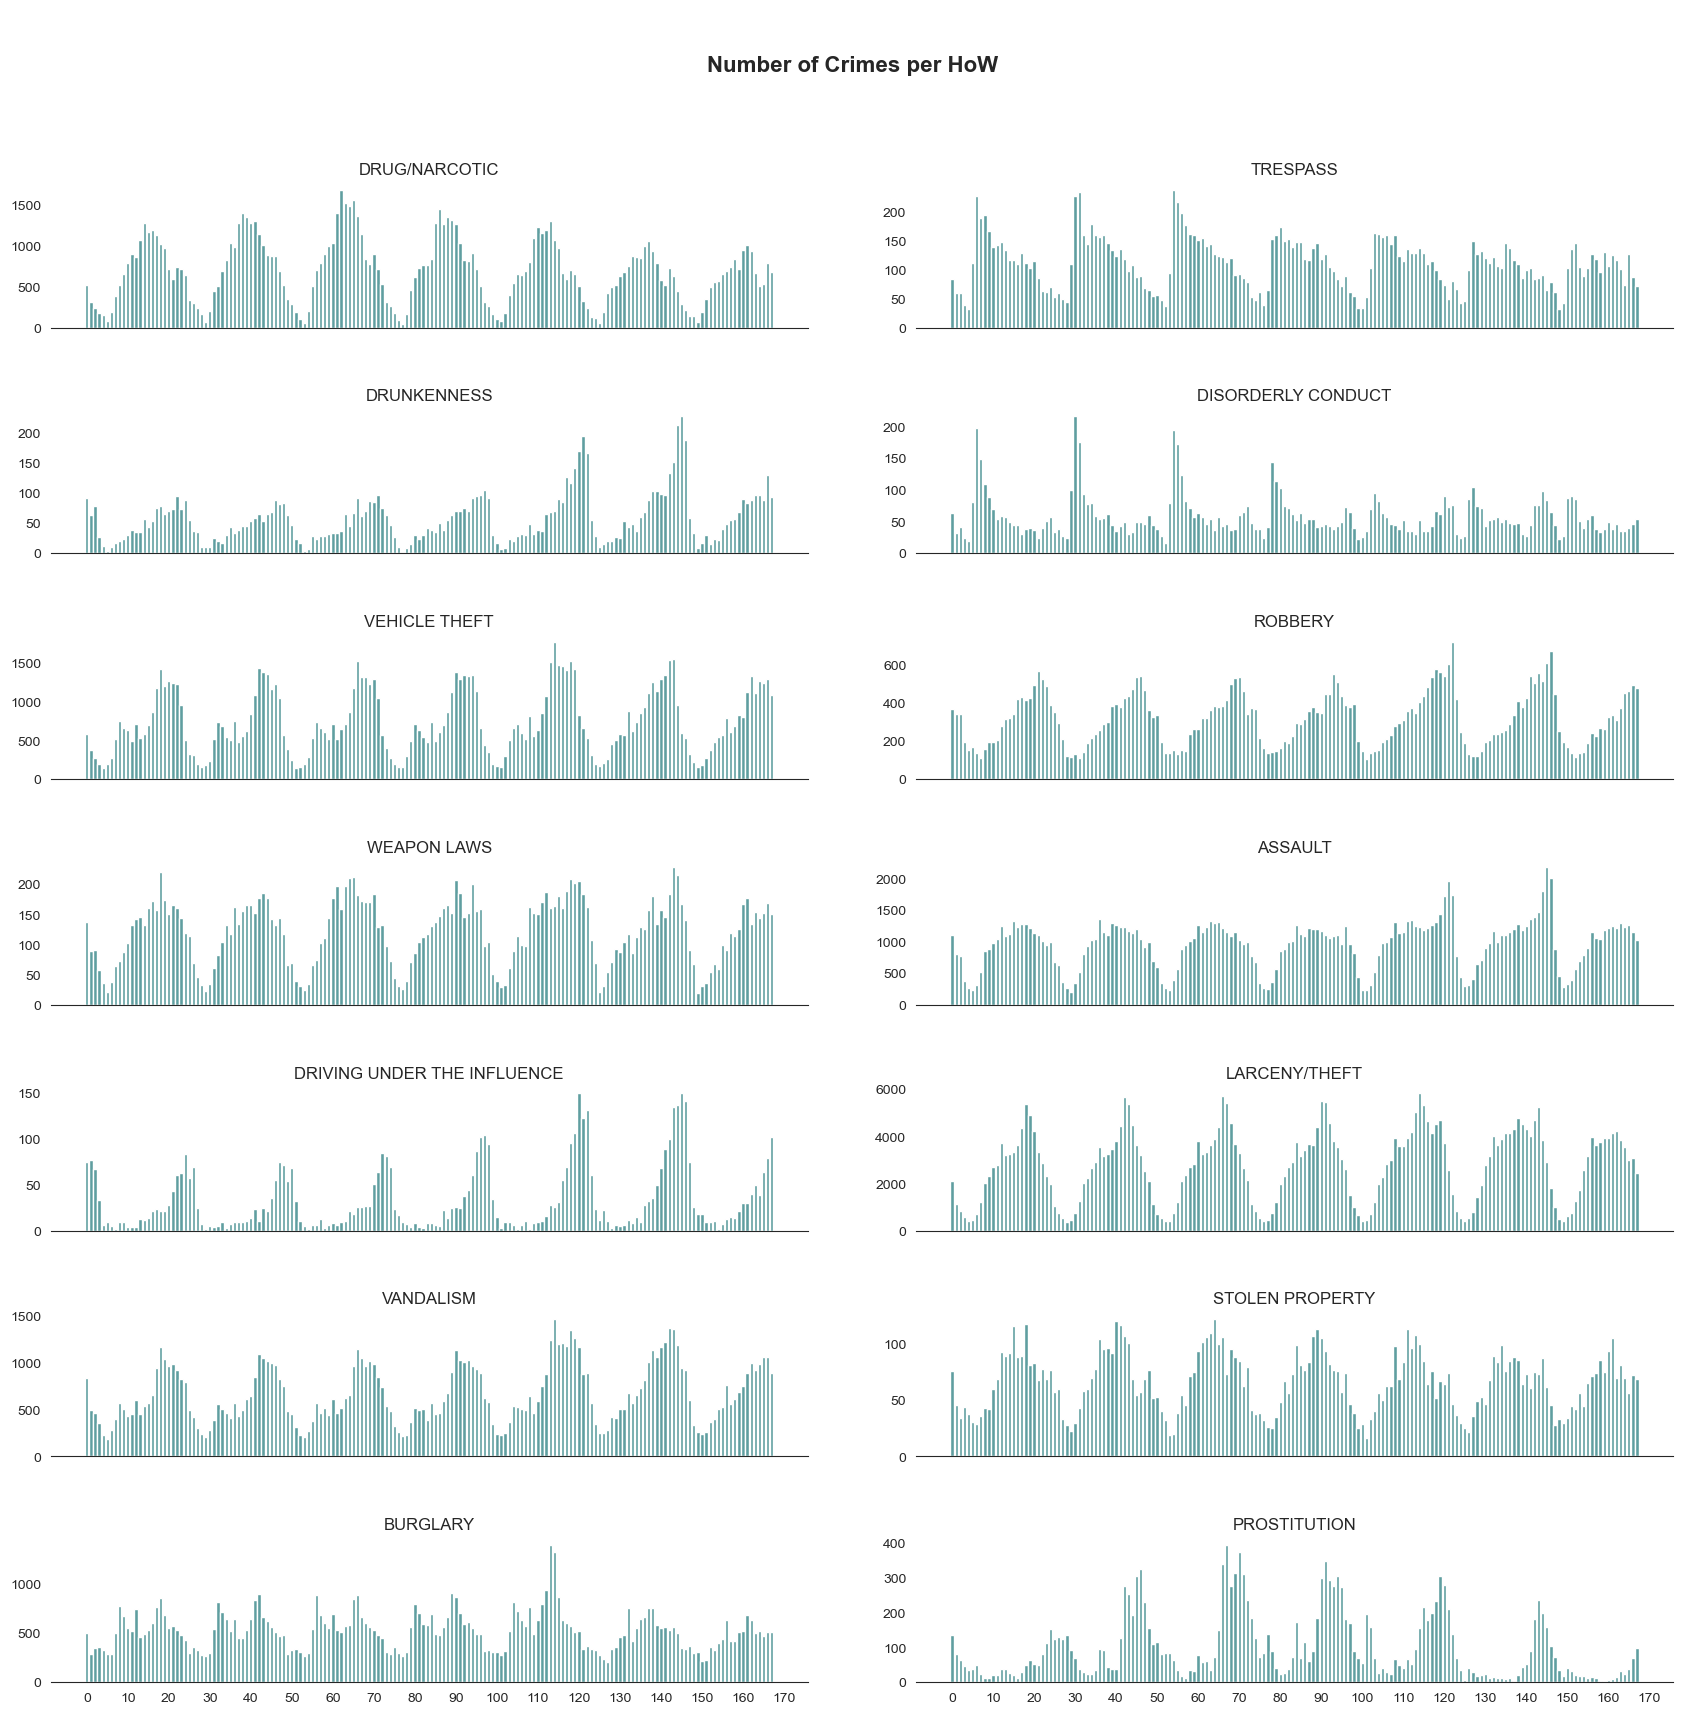

In [11]:
for t in timeframe:
    # Count crime occurences per timeframe by category
    grouped = crime_df.groupby(['Category', t]).size().reset_index(name='counts')
    pivot = grouped.pivot(index=t, columns='Category', values='counts')
    plt.rcParams["figure.figsize"] = (18,18)
    
    # Timeframe plot settings
    fig, axes = plt.subplots(7,2,sharex=True)
    fig.suptitle(f"\n\nNumber of Crimes per {t}", weight='bold', fontsize=16)
    fig.tight_layout(pad=5.0)
    index = list(pivot.index) 
    x_pos = np.arange(len(index))

    for i, c in enumerate(focuscrimes):
        # plot by category
        ax = axes[int(np.floor(i/2)),i%2]
        ax.bar(x_pos, pivot[c], color=plt_color)
        if t=='HoW':
          ticks=np.arange(0,171,10)
          ax.set_xticks(ticks)
          ax.set_xticklabels(ticks)
        else:
          ax.set_xticks(x_pos)
          ax.set_xticklabels(index, rotation=50)
        ax.set_title(f'\n\n{c}')
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)
    plt.show()

**Monthly Occurences:** In general, the occurences of the majority of crime categories does not vary significantly from month to month. Driving under the influence decreases slightly during spring and summer, except from a peak in May. Prostitution seems to be occurring a bit more frequently in January compared to the rest of the year. <br>

**Week Day Occurences:** Prostituion and Drug/narcotics shows surprsing behaviour with mid-week peeks in number of crimes. As expected driving under the influence has a significant increase in occurences during the weekend as well as drunkeness. Crime categories that might be conducted more randomly or spontaneously, such as vandalism, theft, robbery and assault all increse in number of occurences during the weekend.<br>

**Hourly Occurences:**
Tresspass is most likely during mornings from 6AM and occurs with decreasing frequency during the day. This crime type tends to have low frequency during night time. What also seems a bit surprising is that disorderly conduct has significantly peak time at 6-8AM and succeedingly decreases with a higher rate than tresspass. Most other crimes become more frequent during the day and tend to be occuring mostly at evening/night time. As expected, both prostitution and driving under the influence is quite rare during daytime but at night time the frequence increase instantly.<br>

**Hour of Week (HoW) Occurences:** <br>



* Next choose a crime type that you like and create a calendar plot (Week 2, Part 4). Don't forget to comment on patterns you observe.



[]

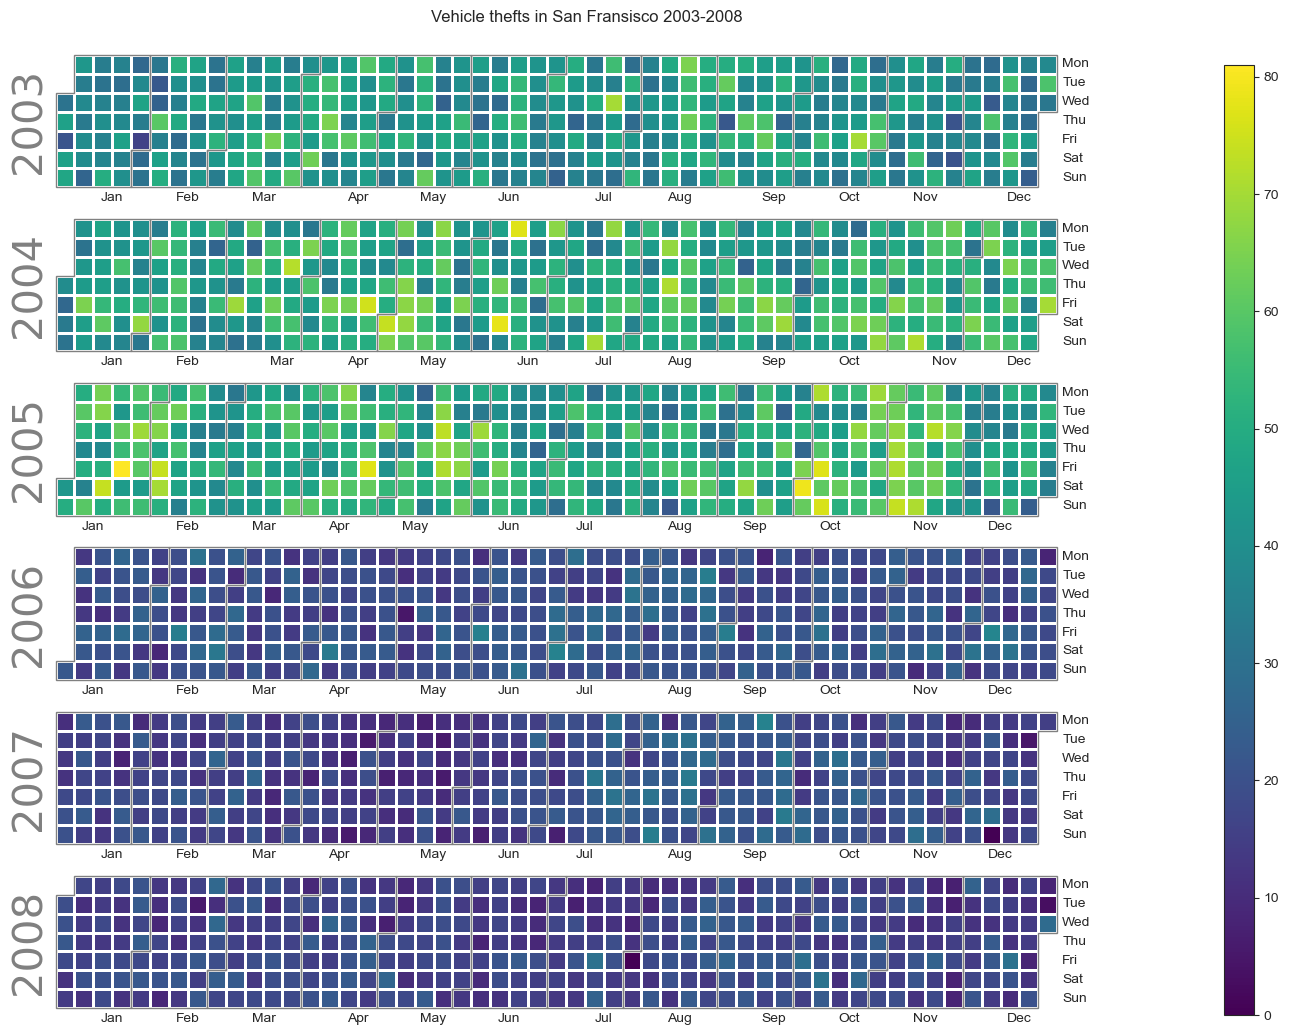

In [14]:
crime_df.Date = pd.to_datetime(crime_df.Date)

font_path = fm.findfont("DejaVu Sans")
fontproperties = fm.FontProperties(fname=font_path, size=20)
yearlabel_kws = dict(fontproperties=fontproperties)


calplot.calplot(
         crime_df[(crime_df.Category == 'VEHICLE THEFT') & (crime_df.year.isin(range(2003,2009)))]\
         .groupby(['Date'])\
         .count().PdId,
         suptitle='Vehicle thefts in San Fransisco 2003-2008', 
         figsize=(15,10), 
         tight_layout=True,
         yearlabel_kws=yearlabel_kws
         )
plt.plot()

From the calendar heatmap above it seems like the crime pattern of `vehicle thefts`changed after 2005. The number of thefts dropped to approx. 0-40 thefts a day in 2006 an onwards, whereas the daily level previously had been 30-80 thefts day. This behaviour could indicate that the poliice department increased their foucs on this crime and successfully decreased the occurences. Other impacts could be changes in law, etc.  


* Finally, choose a different crime type and create a polar plot of its 24hour cycle (Week 2, Part 4). Again, don't forget to comment as you would in a figure text.

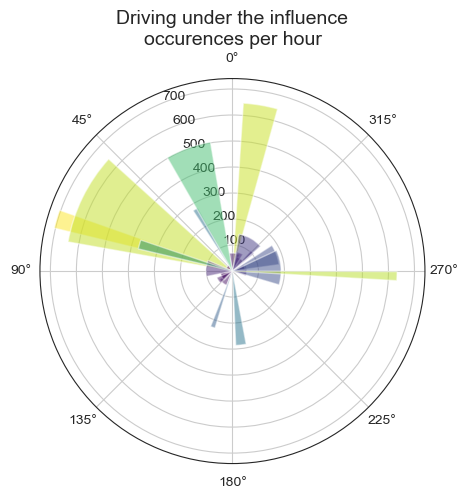

In [117]:
from sklearn.preprocessing import MinMaxScaler

# Set crime category
grouped = crime_df.groupby(['Category','Hour']).size().reset_index(name='counts')
pivot = grouped.pivot(index='Hour', columns='Category', values='counts')
CAT = 'DRUG/NARCOTIC'
CAT = 'DRIVING UNDER THE INFLUENCE'

# Polar Circle settings
N = len(pivot[CAT]) #24
radii =  pivot[CAT]
width = np.pi / 4 * np.random.rand(N)
min_max_scaler = MinMaxScaler()
freq_color = plt.cm.viridis(10*min_max_scaler.fit_transform(np.array(radii).reshape(-1, 1))/ 10.)

# Plot polar circle 
plt.figure(figsize=(5,5))
ax = plt.subplot(projection='polar')
ax.bar(pivot[CAT], 
       radii, width=width, 
       bottom=0.0, color=freq_color, alpha=0.5)
ax.set_theta_zero_location("N")
plt.title(f'{CAT.capitalize()}\noccurences per hour', fontsize=14)
plt.show()

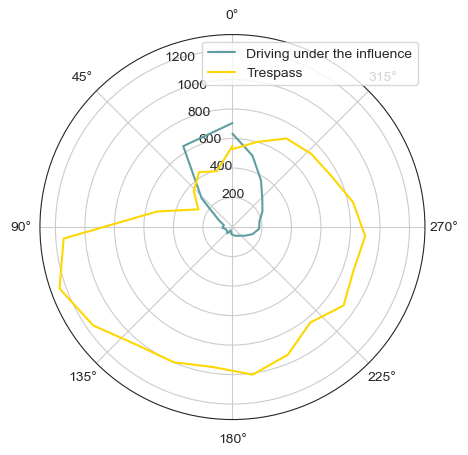

In [116]:
# Plot polar circle 
r = np.arange(N)
theta = np.linspace(0,  2 * np.pi, num=N) 
plt.figure(figsize=(5,5))
ax = plt.subplot(projection='polar')
p1, = ax.plot(theta, pivot[CAT], 
        color=plt_color, label=CAT.capitalize())
p2, = ax.plot(theta, pivot['TRESPASS'], 
        color='gold', label='Trespass')
ax.legend(handles=[p1, p2])
ax.set_theta_zero_location("N")



## A1 Part 2: Dataviz questions 

Have a look at the encoding dataviz lecture (Week 4), then answer the following questions in your own words. 

* Mention 10 examples of ways we can encode data.
* Are all encodings created equally? Why not? Can you think of an example from the previous lectures?
* Mention 3 encodings that are difficult for the human eye to parse. Can you find an example of a visualization online that uses one of those three?
* Explain in your own words: What is the problem with pie-charts?

**Mention 10 examples of ways we can encode data**

A visualization maps data to visual encodings such as;
- position, length, area, shape, color, angle, line weight, line ending, texture, pattern, nodes, links


**Are all encodings created equally? Why not? Can you think of an example from the previous lectures?**

Different encodings have varying strengths and limitations, which can impact how effectively data is conveyed and interpreted by viewers. The effectiveness of an encoding can be influenced by factors such as data complexity, visualization goals, and audience characteristics. Therefore, it's important to carefully consider encodings when designing visualizations, and to choose appropriate encodings.

During Lecture 1, a bar chart was used to visualize the yearly frequency of a particular type of crime throughout the data period of 2003-2017. The bar chart was an effective choice for conveying this information, as it allowed the audience to easily observe and understand the development of the crime frequency over time.

During Lecture 2, we visualized an enriched version of the same crime frequency data using a calendar plot. The calendar plot displayed the daily frequency of the crime type, and utilized additional encodings, such as color, to represent the frequency. By using color in addition to the position of each day on the calendar, the calendar plot allowed for a more nuanced and detailed understanding of the daily fluctuations in crime frequency over time. This would not have been easily conveyed using a bar chart.


**Mention 3 encodings that are difficult for the human eye to parse. Can you find an example of a visualization online that uses one of those three?**

- Angle: Differences in angle can be difficult to accurately perceive and compare, especially when they are small or subtle.

- Color intensity: Color intensity can be challenging to accurately perceive and compare due to factors such as variations in lighting conditions and individual biases.

- Area: Differences in area can be challenging to accurately perceive and compare when they are small or subtle, and can be easily distorted by visual cues such as shading or texture. Additionally, scaling areas appropriately can be difficult in some cases. This is a bit similar to angles.

An example where the angle encoding is used is the pie chart in the [medium](https://medium.com/the-mission/to-pie-charts-3b1f57bcb34a) article which describes poor visualizations and in particular why pie charts should not be used.



<div>
<img src="https://raw.githubusercontent.com/jens-create/socialdata2023/main/files/pie.png" width="400"/>
</div>

The pie chart shows the proportions of different animals in a population. The visualisation is supposed to convey the proporiton of the animals, however, this is very difficult to comprehend. Are there more Cats or Goats? The fact that we cannot answer this question is a clear example of how humans have a difficult to perceive angles. Thus, this illustration are using angles in a poor way.


**Explain in your own words: What is the problem with pie-charts?**

Pie charts are often criticized for their use of angles to represent proportions or percentages. This is because the human eye can have difficulty accurately perceiving and comparing differences in angles, especially when the differences are small or subtle. It in generally recommmended to use other visual encodings such as bar charts to represent proportions or percentages, as these encodings can be easier to accurately perceive and compare.

**Er mine eksempler ok?**
Det er jo lidt counter intuitivt at vælge et eksempel fra nettet hvor man netop basher piecharts.

## A1 Part 3: Visualizing geodata using Plotly

In this sub-assignment I want you to create a choropleth map of San Francisco, showing where it's safest to leave your car on Sundays, following the instructions from Week 3.

We start by downloading the SFPD District shapefiles. A shapefile is a dictionary storing geographic locations and associated attribute information.  
The district coordinates (latitude,longitude) is the ID. 

In [11]:
# Loading the SFPD District shapefiles
with urlopen('https://raw.githubusercontent.com/suneman/socialdata2022/main/files/sfpd.geojson') as response:
    districts = json.load(response)

Next, we create a new dataframe, as we are only interested in investigating where it's safest to leave your car on Sundays.  
In the new dataframe we only have `DayOfWeek = Sunday` and `Category = VEHICLE THEFT`. 

In [14]:
# Creating sub dataframe only consisting of sundays and vehicle thefts
df_map = crime_df[crime_df['DayOfWeek']=='Sunday']
df_map = df_map[df_map['Category']=='VEHICLE THEFT'] 

The district is the ID, that we wish to base our choropleth map on. In order to do this, we create a new dataframe consisting of the district name, `PdDistrict`, and the number of vehicle thefts in each district, `COUNT(PdId)`. Thus, we aggregate data by police district.   
  
Remeber that the data consist of data from 2003 to 2017 (whole years). 

In [15]:
#Aggregate data by police district
df_map = df_map.pivot_table(index='PdDistrict', values='PdId', aggfunc='count')
df_map = df_map.reset_index()

The new dataframe looks the following: 

In [16]:
df_map

PdDistrict  PdId
0     BAYVIEW  2297
1     CENTRAL  1482
2   INGLESIDE  2825
3     MISSION  2367
4    NORTHERN  1983
5        PARK  1320
6    RICHMOND  1358
7    SOUTHERN  1540
8     TARAVAL  1928
9  TENDERLOIN   353

We are now ready to plot using the [Choropleth maps](https://plotly.com/python/mapbox-county-choropleth/). From the dataframe above, we can see that the number of vehicle thefts is in the range of $[353, 2825]$, thus we set the color range to $[0, 3000]$. Further, the map is centered on San Francisco's latitude and longitude.

In [17]:
fig = px.choropleth_mapbox(df_map, geojson=districts, locations='PdDistrict', color='PdId',
                           color_continuous_scale="deep",
                           range_color=(0, 3000), # suitable for the data range
                           mapbox_style="carto-positron",
                           zoom=11, center = {"lat": 37.773972, "lon": -122.431297}, # SF's lat and lon
                           opacity=0.7,
                           labels={'PdId':'Vehicle Thefts'}, )

fig.update_layout(title_text = 'Choropleth map of San Francisco showing number of vehicle thefts 2003 to 2017', 
                  margin={"r":0,"t":50,"l":0,"b":0}, height=500, width=900)
fig.show()


When you're done, reflect on the following questions.

**Question:** Based on your map and analysis, where should you park the car for it to be safest on a Sunday? And where's the worst place?
> **Anwer:**   In the map above, you can see that the darker the color, the less safer it is to park your car there. Based on the map above, we can conclude, that on Sundays it is safest to park you car in *Tenderloin* as there have only been 353 vehicle thefts in the period 2003-2017. The worst place to park your car is *Ingleside* as there have been 2825 vehicle thefts in the period 2003-2017. 


Using visualizatios can help us uncover powerful data-patterns. However, when designing visualizations, we need to be aware of several illusions that can lead viewers to misinterpret the data we are showing (i.e. perceptual errors):  

**Question:** Try to change the range of data-values in the plot above. Is there a way to make the difference between district less evident?  
> **Anwer:** From the data, we saw that the number of vehicle thefts is in the range of $[353, 2825]$, thus we originally set the color range to $[0, 3000]$. This was found to be a reasonable range, where the differences between districts were evident. 
> - However, if we increase the range to $[0, 10000]$ the difference between districts are less evident.
> - The color and opacity of the map is also crucial to show the differences between the districts.  

> Let's take a look at these two ways of decreasing the evidence. 

In [18]:
fig = make_subplots(rows=1, cols=2, subplot_titles=['Change in data range', 'Change in colorscale and opacity'],
    specs=[[{"type": "mapbox"}, {"type": "mapbox"}]])

# Making a choropleth map where we change the data range from [0, 3000] to [0, 10000]
fig.add_trace(go.Choroplethmapbox(geojson=districts, locations=df_map['PdDistrict'], z=df_map['PdId'],
                                  colorscale='deep', marker=dict(opacity=0.7), 
                                  zmin=0, zmax=10000,
                                  colorbar=dict(thickness=20, x=0.46)),
                                  row=1, col=1)

# Making a choropleth map where we change the colorscale and decrease the opacity from 0.7 to 0.4
fig.add_trace(go.Choroplethmapbox(geojson=districts, locations=df_map['PdDistrict'], z=df_map['PdId'],
                                  colorscale='Mint', marker=dict(opacity=0.4, line_width=0.5), 
                                  zmin=0, zmax=3000,
                                  colorbar=dict(thickness=20, x=1.02)),
                                  row=1, col=2)
        
fig.update_mapboxes(bearing=0, center = {"lat": 37.773972, "lon": -122.431297 }) # Centering the maps around SF
fig.update_layout(margin=dict(l=0, r=0, t=20, b=10), height=400, width=950) # Adjusting the margins and dimensions
fig.update_layout(mapbox1=dict(zoom=10.5, style='carto-positron'), # Choosing the zoom and style
                  mapbox2=dict(zoom=10.5, style='carto-positron')) # Choosing the zoom and style

fig.show()

The impact of increasing the data range (left) and changing the colorscale and decreasing the opacity (right) is shown in the choropleth maps above.   

*In the map to the left*, we have changed the range from $[0, 3000]$ to $[0, 10000]$. By changing the data range we obtain a map, where the differences are less evident between the different districts. This shows the importance of investigating your data to select a suitable data range.   

*In the map to the right*, we have changed the colorscale from `deep` to `Mint` and the opacity from $0.7$ to $0.4$. By changing these, we again obtain a map, where the differences are less evident. This shows the importance of tuning the color and opacity. This is done by testing different options.  

**Question:** Why do you think perceptual errors are a problem? Try to think of a few examples. 
> Visualizations present important findings and they are often used in a decision-making process. Perceptual errors can lead the viewers of the visualization to misinterpret the data and thereby it can disort the decision or judgement. In this San Francisco case it can mislead the person looking for a safe place to park its car, such that she/he choose a bad district, consequently leading to car theft.   

## A1 Part 4: Errors in the data

We started the course by plotting simple histogram and bar plots that showed a lot of cool patterns. But sometimes the binning can hide imprecision, irregularity, and simple errors in the data that could be misleading. In the work we've done so far, we've already come across at least three examples of this in the SF data (listed in Part 3 of Week 4). 

The data errors we discovered at the end of Week 4 become difficult to notice when we aggregate data (and when we calculate mean values, as well as statistics more generally). Thus, when we visualize, errors become difficult to notice when binning the data. We explore this process in the exercise below.

* In each of the 3 examples we listed during Week 4, describe in your own words how the data-errors I call attention to above can bias the binned versions of the data. 
* Also, briefly mention how not noticing these errors can result in misconceptions about the underlying patterns of what's going on in San Francisco (and our modeling).
* Find your own example of human noise in the data and visualize it.


**In each of the 3 examples we listed during Week 4, describe in your own words how the data-errors I call attention to above can bias the binned versions of the data.**

Regarding the spike in crime frequency on Thursdays, if we only look at binned data, we might mistakenly conclude that crime is more likely to occur on Thursdays than on other days of the week. This could lead to an incorrect allocation of police resources, for example. Similarly, the binned data might suggest that there is some sort of regularity or pattern in the occurrence of crimes with timestamps of :00, :15, :30 or :45, when in reality this could be due to data collection errors or biases.

**Also, briefly mention how not noticing these errors can result in misconceptions about the underlying patterns of what's going on in San Francisco (and our modeling).**

Not noticing these errors can result in misconceptions about the underlying patterns of crime in San Francisco, which can ultimately impact policy and decision-making.

**Find your own example of human noise in the data and visualize it.**

???